# bayesloop tutorial

This notebook is designed to provide a step-by-step guide describing the main features of *bayesloop*. The tutorial is mainly based on a real-world data set that has been studied extensively in the literature (see this [article](http://www.dima.unige.it/~riccomag/Teaching/ProcessiStocastici/coal-mining-disaster-original%20paper.pdf), or the [PyMC tutorial](https://pymc-devs.github.io/pymc/tutorial.html)). It consists of the annual number of coal mining disasters in the United Kingdom from 1851 to 1962.

**Contents**
1. [Basic data study](#section_1)<br>
  1.1 [Study class](#section_1.1)<br>
  1.2 [Data import](#section_1.2)<br>
  1.3 [Observation model](#section_1.3)<br>
  1.4 [Transition model](#section_1.4)<br>
  1.5 [Parameter grid](#section_1.5)<br>
  1.6 [Model fit](#section_1.6)<br>
  1.7 [Plotting](#section_1.7)<br>
2. [Model selection](#section_2) (TODO)
3. [Model optimization](#section_3) (TODO)
4. [Change-point study](#section_4) (TODO)
5. [Online study](#section_5) (TODO)

<a id='section_1'></a>
## 1. Basic data study
The first chapter of the tutorial introduces the main class of the module, `Study`. We provide a detailed description of how to import data, set the observation model and transition model, specify the parameter grid and perform the model fit. Finally, a plotting function to display the results is discussed briefly.

<a id='section_1.1'></a>
### 1.1 Study class
To start a new data study/analysis, create a new instance of the `Study` class:

In [1]:
import bayesloop as bl

S = bl.Study()

+ Created new study.


This object is central to an analysis conducted with *bayesloop*. It stores the data and further provides the methods to perform probabilistic inference on the models defined within the class, as described below.

<a id='section_1.2'></a>
### 1.2 Data import
In this first study, we use a simple, yet instructive example of heterogeneous time series, the annual number of coal mining accidents in the UK from 1851 to 1962. The data is imported as a NumPy array:

In [2]:
import numpy as np

data = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                 3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                 0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                 3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

S.loadData(data)

    + Successfully imported array.


Note that this particular data set is also hard-coded into the `Study` class, for convenient testing:

In [3]:
S.loadExampleData()

    + Successfully imported example data.


In case you have multiple observations for each time step, you may also provide the data in the form `np.array([[x1,y1,z1], [x2,y2,z2], ..., [xn,yn,zn]])`. Missing data points should be included as `np.nan`.

<a id='section_1.3'></a>
### 1.3 Observation model
The first step to create a probabilistic model to explain the data is to define the **observation model**, or **likelihood**. The observation model states the probability (density) of a data point at time $t$, given the parameter values at time $t$ and possibly past data points.

As coal mining disasters fortunately are rare events, we may model the number of accidents per year by a [Poisson](https://en.wikipedia.org/wiki/Poisson_distribution) distribution (data from subsequent years is assumed to be uncorrelated):

In [4]:
M = bl.observationModels.Poisson()
S.setObservationModel(M)

    + Observation model: Poisson


Note that you can also use the following short form to define observation models: `M = bl.om.Poisson()`. All currently implemented observation models can be looked up in `observationModels.py`.

<a id='section_1.4'></a>
### 1.4 Transition model
As the dynamics of many real-world systems are the result of a multitude of underlying processes that act on different spatial and time scales, common statistical models with static parameters often miss important aspects of the systems' dynamics (see e.g. this [article](http://www.nature.com/articles/ncomms8516)). *bayesloop* therefore calls for a second model, the **transition model**, which describes the temporal changes of the model parameters.

As stated above, we model the observed data by a Poisson distribution with one parameter, the rate $\lambda$ (directly decribing the average number of disasters per year). You can retrieve a list of parameters from the chosen observation model:

In [5]:
M.parameterNames

['lambda']

In this example, we assume that $\lambda$ itself may change gradually over time and choose a Gaussian random walk with the standard deviation $\sigma=0.2$ as transition model. The value of the Hyper-parameter $\sigma$ is set from the beginning, but can be optimized (see [Sect. 3](#section_3)).

In [6]:
K = bl.transitionModels.GaussianRandomWalk(sigma=0.2)
S.setTransitionModel(K)

    + Transition model: Gaussian random walk


Note that you can also use the following short form to define transition models: `M = bl.tm.GaussianRandomWalk()`. All currently implemented transition models can be looked up in `transitionModels.py`.

<a id='section_1.5'></a>
### 1.5 Parameter grid
While many inference algorithms designed for hierarchical time series analysis rely on [MCMC](http://www.cs.ubc.ca/~arnaud/andrieu_defreitas_doucet_jordan_intromontecarlomachinelearning.pdf) techniques, *bayesloop* chooses a grid-based approach. All probability distributions are discretized on a regular grid of parameter values. While this approach restricts the choice of observation models to those with only few parameters, it allows to perform very fast probabilistic inference, model selection and model optimization.

The parameter grid has be configured prior to calling any fit- or optimization-routine. First, the grid size has to be set for each parameter (here, only $\lambda$):

In [7]:
S.setGridSize([1000])

Second, parameter boundaries have to be set. One has to provide a list of lists, where each inner list consists of a lower and an upper boundary value. Note that choosing the boundaries to narrow may negatively affect the outcome of the analysis. In case the inferred parameter values come close to the boundary values, one should consider re-running the analysis with looser boundaries.

In our example, we restrict the annual disaster rate to the interval $[0,6]$. We will see that this is sufficient when plotting the results below.

In [8]:
S.setBoundaries([[0, 6]])

Note that if you do not provide a proper grid size, *bayesloop* will set it automatically to the default value stored in each observation model. In case no parameter boundaries are given, *bayesloop* will offer to set default values. Keep in mind, though, that correct parameter boundaries strongly depend on the data set at hand.

<a id='section_1.6'></a>
### 1.6 Model fit

At this point, the hierarchical time series model for the coal mining data set is properly defined and we may continue to perform the model fit. *bayesloop* employs a forward-backward algorithm that is based on [Hidden Markov models](http://www.cs.sjsu.edu/~stamp/RUA/HMM.pdf). The inference algorithm is implemented by the `fit` method:

In [9]:
S.fit()

+ Started new fit:
    + Formatted data.
    + Finished forward pass.
    + Log10-evidence: -75.49376
    + Finished backward pass.
    + Computed mean parameter values.


By default, `fit` computes the so-called *smoothing distribution* of the model parameters for each time step. This distribution states the probability (density) of the parameter value at a time step $t$, given all past and future data points. All distributions have the same shape as the parameter grid, and are stored in `S.posteriorSequence` for further analysis. Additionally, the mean values of each distribution are stored in `S.posteriorMeanValues`, as point estimates. Finally, the logarithmic value of the evidence, the probability of the data given the chosen model, is stored in `S.logEvidence` (see [Sect. 2](#section_2)). 

To simulate an online-analysis, where at each step in time $t$, only past data points are available, one may provide the keyword-argument `forwardOnly=True`. In this case, only the *forward*-part of the algorithm in run. The resulting parameter distributions are called *filtering distributions*.

<a id='section_1.7'></a>
### 1.7 Plotting
To display the temporal evolution of the model parameters, *bayesloop* provides a simple plot function `plotParameterEvolution` that displays the mean values together with its marginal distributions for one parameter of the model. The parameter to be plotted can be chosen by providing an index or the name of the parameter (by default, the first one is plotted).

Here, we plot the original data (in red) together with the inferred disaster rate (mean value in black, marginal distirbution in blue):

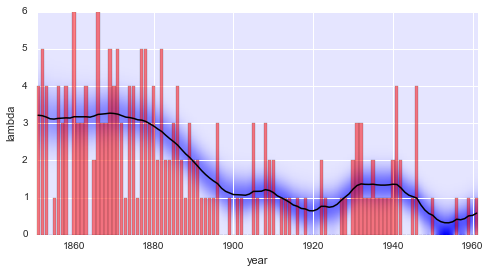

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

# plot of raw data
plt.bar(range(1851, 1962), S.rawData, align='center', facecolor='r', alpha=.5)

# parameter plot
bl.plotParameterEvolution(S, param='lambda', xLower=1851, xUpper=1962)

plt.xlim([1850, 1962])
plt.xlabel('year')

From this first analysis, we may conclude that before $1880$, an average of $\approx 3$ accidents were recorded. This changes significantly between $1880$ and $1900$, when the accident-rate drops to $\approx 1$. Studies like this one may in the future help to objectively quantify the effects of policies, like safety regulations.